In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import category_encoders as ce
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

# Подгрузим наши данные из соревнования

In [50]:
hotels_test = pd.read_csv('input/hotels_test.csv')
hotels_train = pd.read_csv('input/hotels_train.csv')
submission = pd.read_csv('input/submission.csv')

In [5]:
hotels_test.head(5)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644


In [6]:
hotels_train.head(5)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


In [7]:
# дря корректной обработки признаков объединяем трейн и тест в один датасет
hotels_train['sample'] = 1 # помечаем где у нас трейн
hotels_test['sample'] = 0 # помечаем где у нас тест
hotels_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = hotels_test.append(hotels_train, sort=False).reset_index(drop=True) # объединяем

C:\Users\rodni\AppData\Local\Temp\ipykernel_2296\126525529.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = hotels_test.append(hotels_train, sort=False).reset_index(drop=True) # объединяем


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Признаки

hotel_address - адрес отеля

review_date - дата, когда рецензент разместил соответствующий отзыв

average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год

hotel_name - название отеля

reviewer_nationality - национальность рецензента

negative_review - отрицательный отзыв, который рецензент дал отелю

review_total_negative_word_counts - общее количество слов в отрицательном отзыв

positive_review - положительный отзыв, который рецензент дал отелю

review_total_positive_word_counts - общее количество слов в положительном отзыве

reviewer_score - оценка, которую рецензент поставил отелю на основе своего опыта

total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом

total_number_of_reviews - общее количество действительных отзывов об отеле

tags - теги, которые рецензент дал отелю

days_since_review - продолжительность между датой проверки и датой очистки

additional_number_of_scoring - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки

lat - широта отеля

lng - долгота отеля

# Работа с пропущенными значениями

Пропуски обнаружены только в двух признаках *lat* и *lng*. Посмотрим на их распределие, чтобы узнать на что можно заменить пропуски

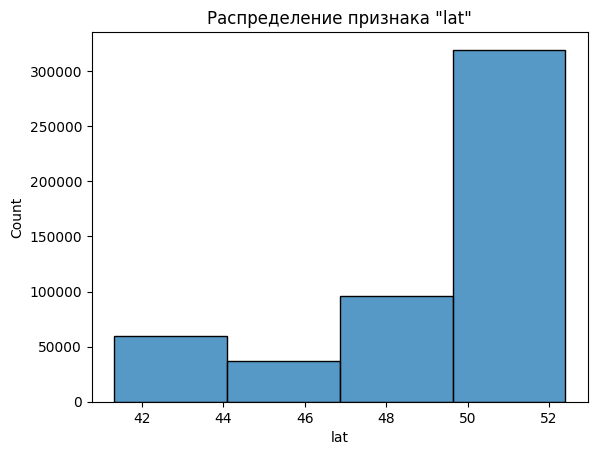

In [9]:
sns.histplot(x=data['lat'], bins=4)
plt.title('Распределение признака "lat"');

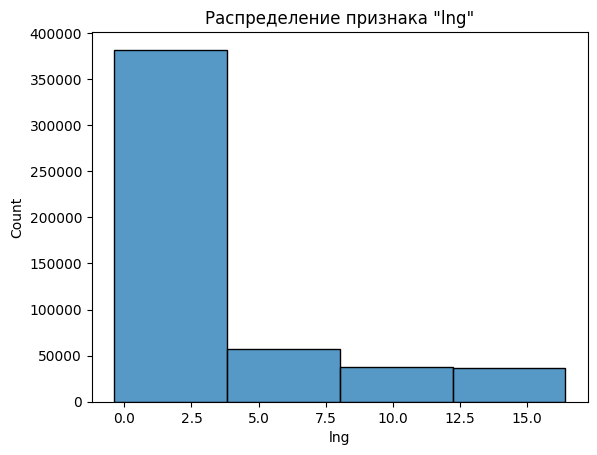

In [10]:
sns.histplot(x=data['lng'], bins=4)
plt.title('Распределение признака "lng"');

Распределение не нормальное, поэтому заменим пропуски на значение медианы

In [11]:
data['lat'] = data['lat'].fillna(data['lat'].median())
data['lng'] = data['lng'].fillna(data['lng'].median())

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

# НОВЫЕ ПРИЗНАКИ

Из признака *review_date* создадим 2 признака *year* и *month*

In [13]:
data['review_date'] = pd.to_datetime(data['review_date'])
data['year'] = data['review_date'].dt.year
data['month'] = data['review_date'].dt.month

К признакам *hotel_name* и *reviewer_nationality* применим: Двоичное Кодирование .Так как признаки номинальные и имеют большое кол-во уникальных значений

In [14]:
bin_encoder = ce.BinaryEncoder(cols=['hotel_name']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['hotel_name'])
data = pd.concat([data, type_bin], axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 31 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

In [15]:
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 39 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

Создадим признак *how_many_nights* из признака *tags*. Который покажен на сколько ночей оставался рецензент


In [16]:
def how_many_nights(tags):
    tag_list = tags.replace('[', '').replace(']', '').replace("'", '').strip().split(' ,  ')  # Разделите теги по запятой (или другому символу) и удалите пробелы с начала и конца тега
    for elem in tag_list:
        if 'Stayed' in elem:
            return elem.split()[1]
    return 0
            
data['how_many_nights'] = data['tags'].apply(how_many_nights)
data['how_many_nights'] = data['how_many_nights'].astype('int')

Преобразуем признак *days_since_review* в числовой тип 

In [17]:
data['days_since_review_int'] = data['days_since_review'].apply(lambda x: int(x.split()[0]))

Преобразуем признак positive_review, где 1 - позитивный отзыв, 0 - не позитивный

In [18]:
def positive_review(review):
    if review == 'No Positive' or review == ' Nothing' or review == ' Nothing ' or review ==  ' nothing':
        return 0
    else: return 1
     

data['positive_review_int'] = data['positive_review'].apply(positive_review)

Из признака *hotel_address* создадим признак *hotel_country*. 

In [19]:
data['hotel_address'].unique()[0:10]

array(['Via Senigallia 6 20161 Milan Italy',
       'Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands',
       'Mallorca 251 Eixample 08008 Barcelona Spain',
       'Piazza Della Repubblica 17 Central Station 20124 Milan Italy',
       'Singel 303 309 Amsterdam City Center 1012 WJ Amsterdam Netherlands',
       'Coram Street Camden London WC1N 1HT United Kingdom',
       'Empire Way Wembley Brent London HA9 8DS United Kingdom',
       '1 Shortlands Hammersmith and Fulham London W6 8DR United Kingdom',
       '35 Rue Caumartin 9th arr 75009 Paris France',
       '49 Gloucester Place Marble Arch Westminster Borough London W1U 8JE United Kingdom'],
      dtype=object)

In [20]:
data['country'] = data['hotel_address'].apply(lambda x: 'United Kingdom' if x.split()[-1] == 'Kingdom' else x.split()[-1])

Теперь к созданному признак *country* применим Однократное кодирование: *ONE-HOT ENCODING*

In [21]:
data = pd.get_dummies(data, columns=['country'])

In [22]:
country_list = ['United Kingdom', 'Spain', 'France', 'Netherlands', 'Austria', 'Italy']
for i in country_list:
    data['country_'+ i] = data['country_' + i].astype('int')

# Удаление строковых значений

Удаляем строковые признаки: *hotel_address, review_date, hotel_name, reviewer_nationality, negative_review, positive_review, tags, days_since_review* и признак *review_date*, которые больше не пригодятся

In [23]:
object_columns = data.select_dtypes(include=['object'])

In [24]:
data.drop(object_columns.columns, axis=1, inplace=True)
data.drop('review_date', axis=1, inplace=True)

# Преобразование признаков

Проведем преобразования над количественными (непрерывными) признаками

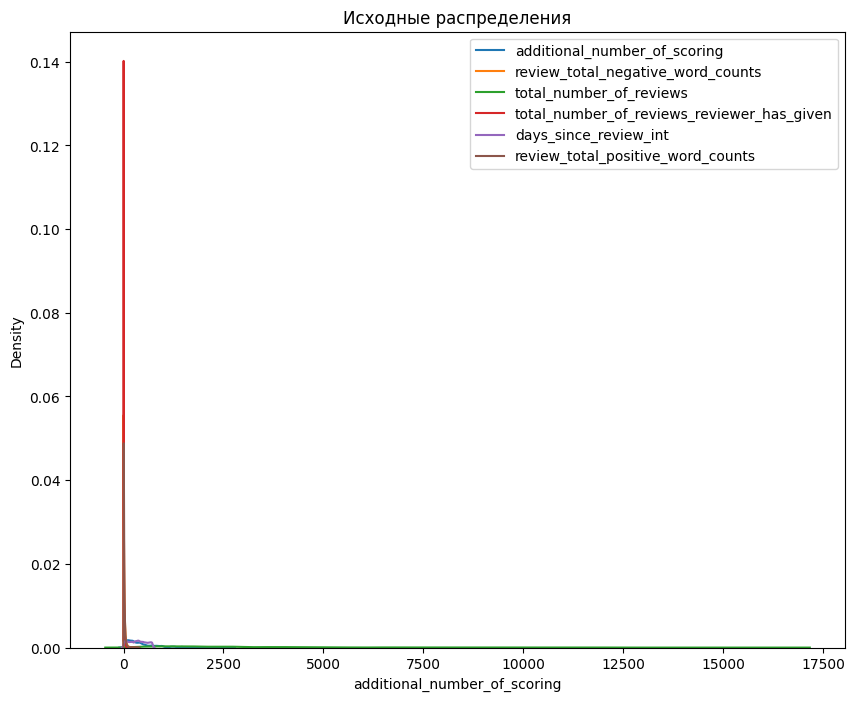

In [25]:
fig, axes = plt.subplots(ncols=1, figsize=(10, 8))
axes.set_title('Исходные распределения')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(data['additional_number_of_scoring'], ax=axes, label ='additional_number_of_scoring')
sns.kdeplot(data['review_total_negative_word_counts'], ax=axes, label ='review_total_negative_word_counts')
sns.kdeplot(data['total_number_of_reviews'], ax=axes, label ='total_number_of_reviews')
sns.kdeplot(data['total_number_of_reviews_reviewer_has_given'], ax=axes, label ='total_number_of_reviews_reviewer_has_given')
sns.kdeplot(data['days_since_review_int'], ax=axes, label ='days_since_review_int')
sns.kdeplot(data['review_total_positive_word_counts'], ax=axes, label ='review_total_positive_word_counts')

plt.legend()

Нормального распределения среди данных признаков не наблюдается, поэтому проведём нормализацию распределений признаков, используя MinMaxScaler

In [26]:
mm_scaler =  MinMaxScaler()
col_names = ['review_total_negative_word_counts', 'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given', 
             'days_since_review_int', 'review_total_positive_word_counts', 'additional_number_of_scoring']
df_scaler = mm_scaler.fit_transform(data[col_names])

df_scaler = pd.DataFrame(df_scaler, columns=col_names)
data = data.drop(col_names, axis=1)
data = pd.concat([data, df_scaler], axis=1)

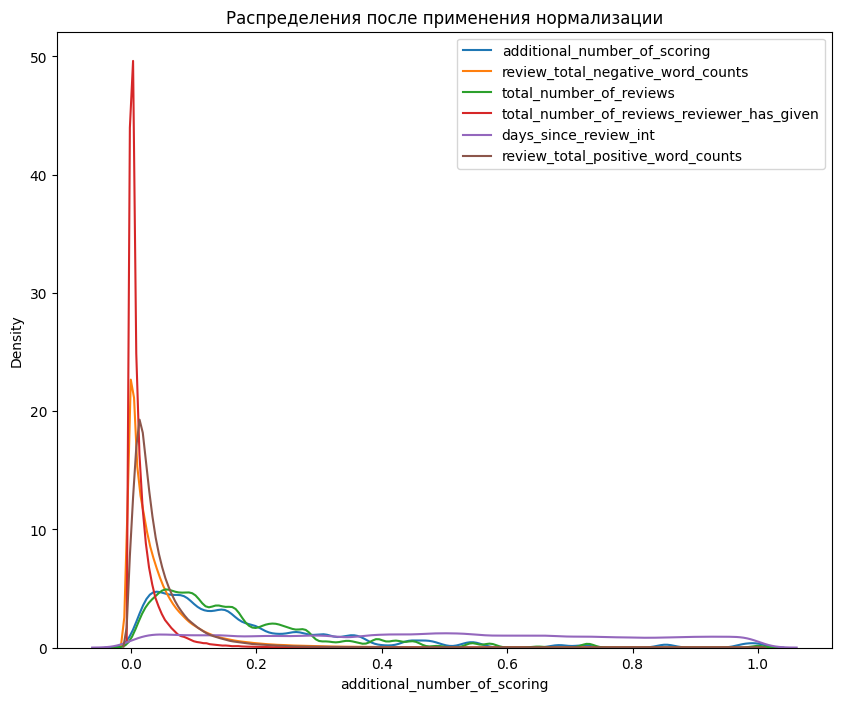

In [27]:
fig, axes = plt.subplots(ncols=1, figsize=(10, 8))
axes.set_title('Распределения после применения нормализации')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(data['additional_number_of_scoring'], ax=axes, label ='additional_number_of_scoring')
sns.kdeplot(data['review_total_negative_word_counts'], ax=axes, label ='review_total_negative_word_counts')
sns.kdeplot(data['total_number_of_reviews'], ax=axes, label ='total_number_of_reviews')
sns.kdeplot(data['total_number_of_reviews_reviewer_has_given'], ax=axes, label ='total_number_of_reviews_reviewer_has_given')
sns.kdeplot(data['days_since_review_int'], ax=axes, label ='days_since_review_int')
sns.kdeplot(data['review_total_positive_word_counts'], ax=axes, label ='review_total_positive_word_counts')

plt.legend()

# Отбор признаков

<AxesSubplot: >

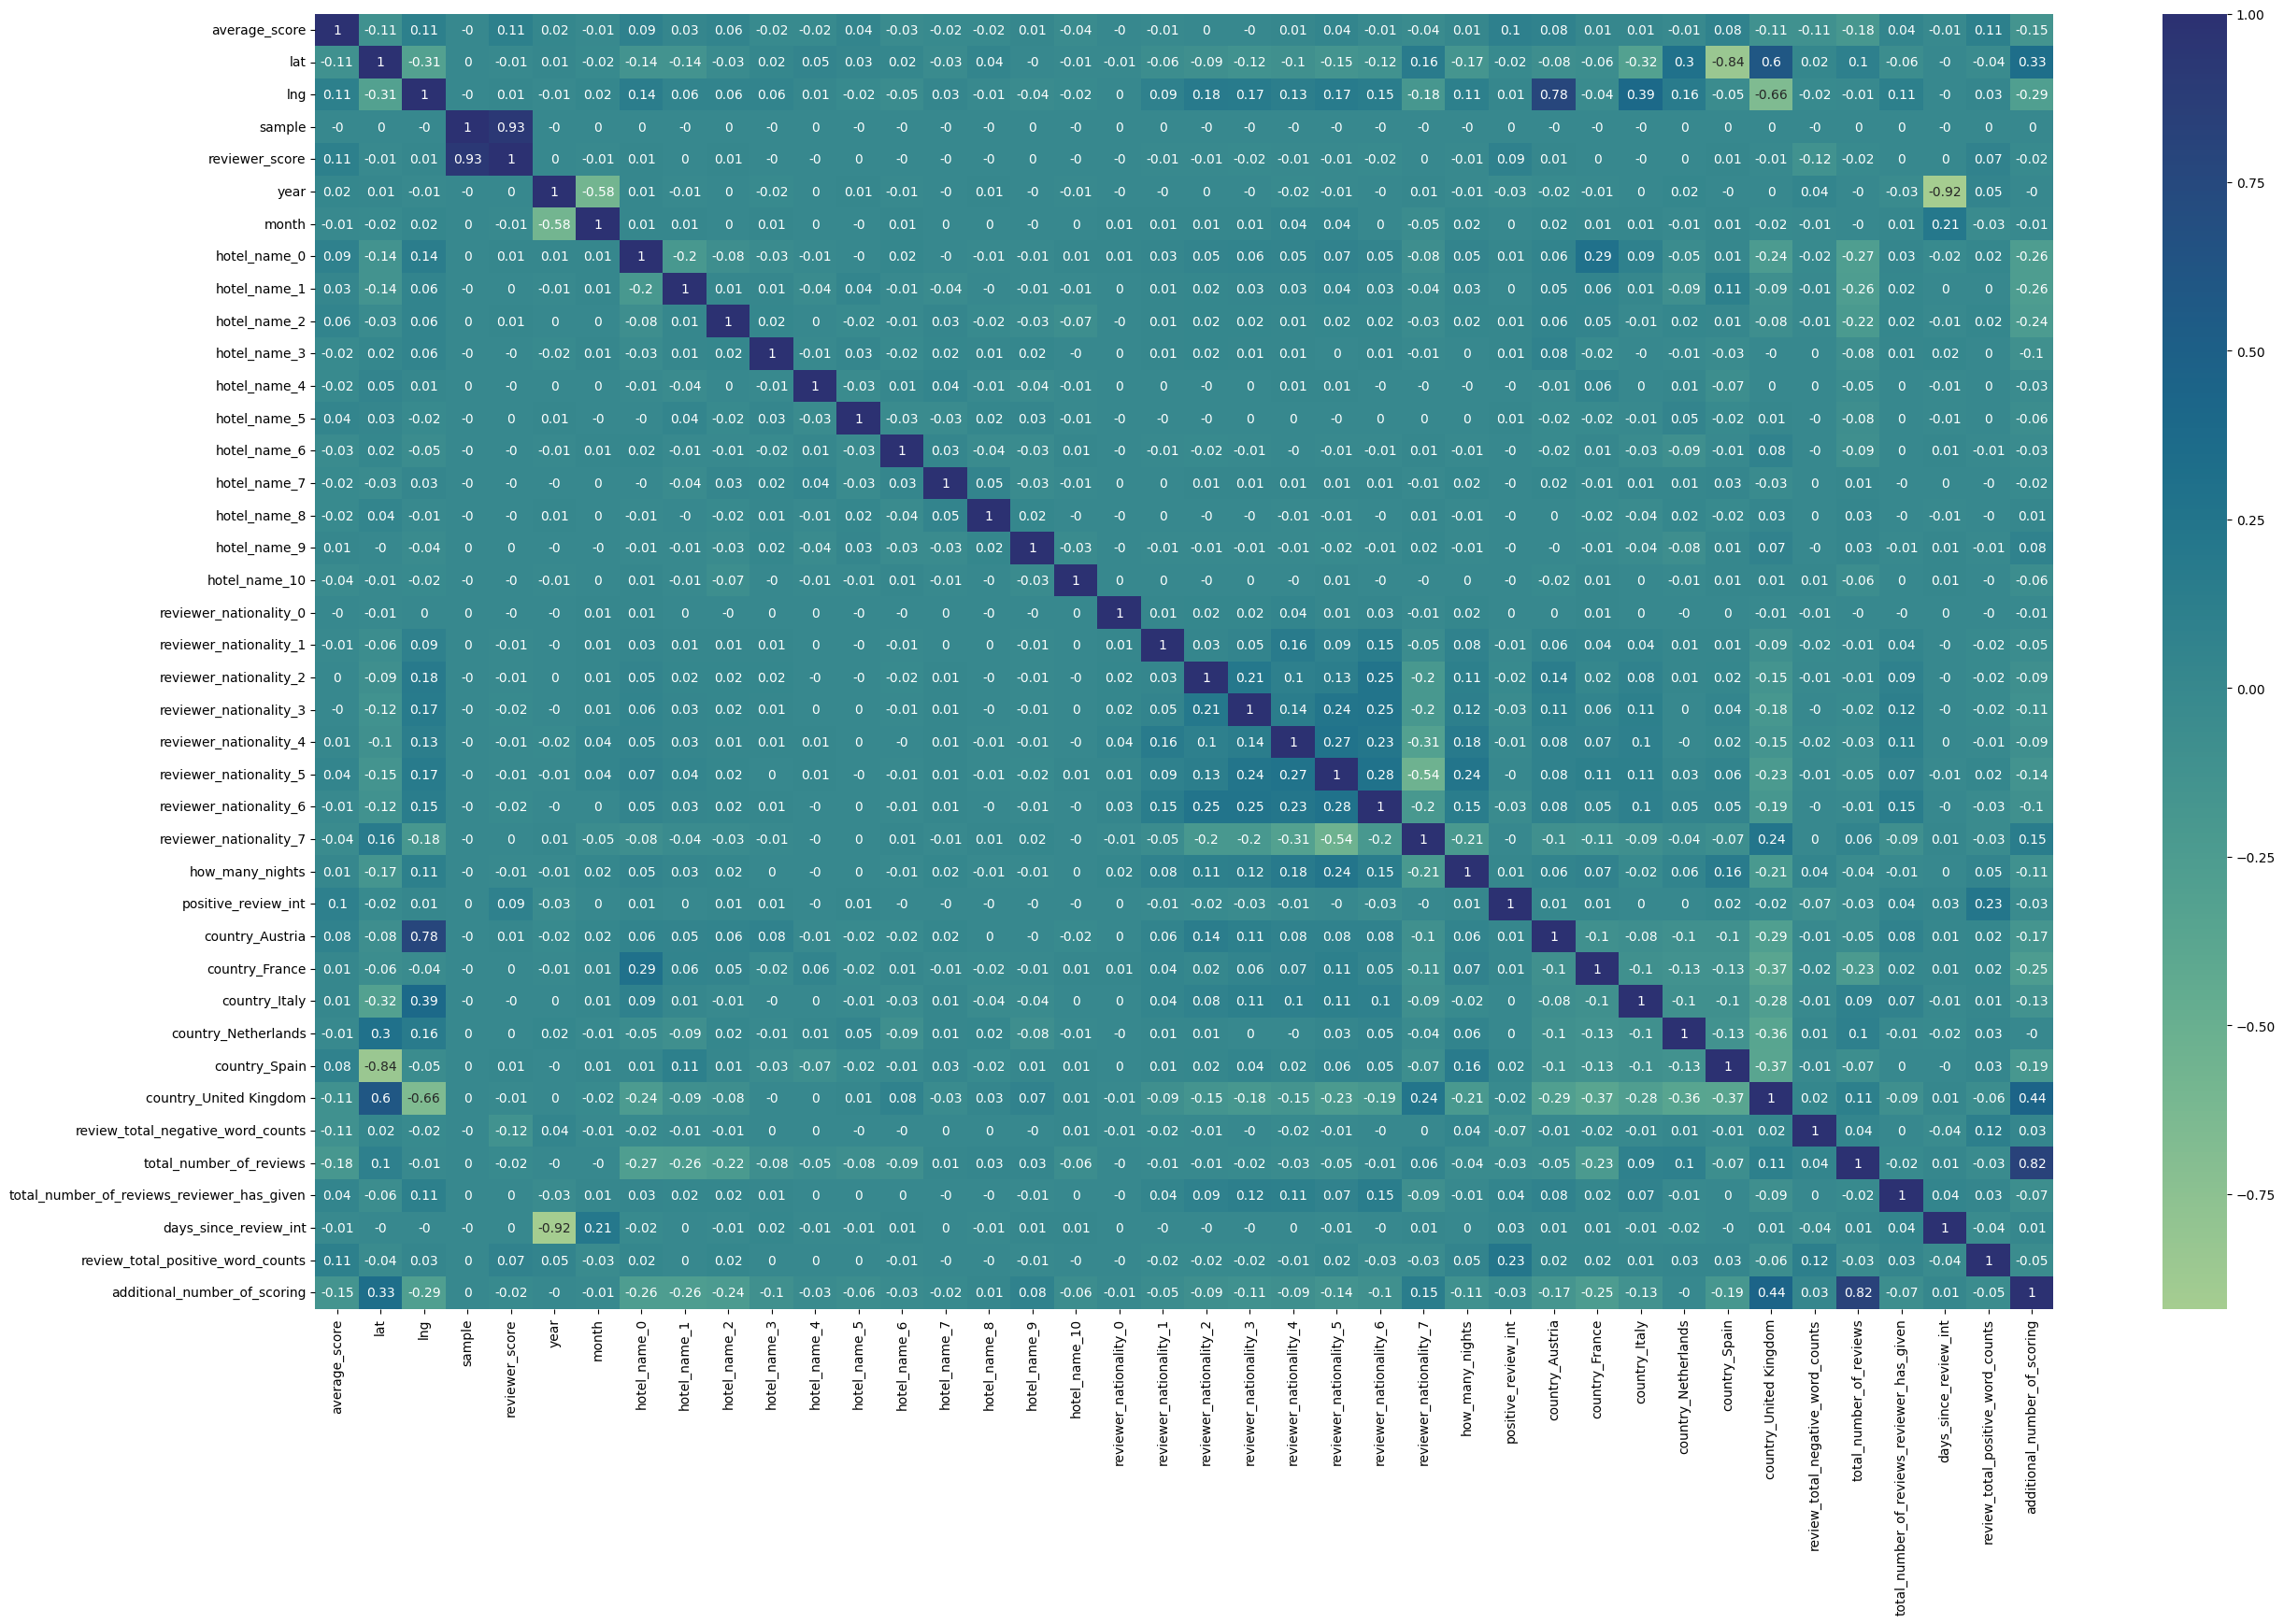

In [28]:
fig = plt.figure(figsize=(30, 18))
sns.heatmap(round(data.corr(), 2), annot=True, cmap="crest")

In [29]:
hotels_corr = data.corr().abs().unstack().reset_index()
hotels_corr = hotels_corr.rename(columns={0:'corr'})
hotels_corr[(hotels_corr['corr'] > 0.7) & (hotels_corr['corr'] != 1)]

,level_0,level_1,corr
72,lat,country_Spain,0.843640
108,lng,country_Austria,0.777596
124,sample,reviewer_score,0.931753
163,reviewer_score,sample,0.931753
237,year,days_since_review_int,0.917266
1122,country_Austria,lng,0.777596
1281,country_Spain,lat,0.843640
1439,total_number_of_reviews,additional_number_of_scoring,0.824884
1485,days_since_review_int,year,0.917266
1595,additional_number_of_scoring,total_number_of_reviews,0.824884


Для оценки значимости категориальных признаков будем использовать тест хи-квадрат, для непрерывных признаков — тест ANOVA.

In [30]:
# непрерывные признаки
num_cols = ['additional_number_of_scoring', 'review_total_negative_word_counts', 'review_total_positive_word_counts', 'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given', 'days_since_review_int']
cat_cols =[] # категориальные признаки
for i in data.columns:
    if i not in num_cols:
        cat_cols.append(i)

Удаляем лишние признаки

In [31]:
cat_cols.remove('reviewer_score')
cat_cols.remove('lng')
cat_cols.remove('sample')

Разбиваем датафрейм на части, необходимые для обучения и тестирования модели   Х — данные с информацией об отелях, у — целевая переменная (рейтинги отелей)

In [32]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data['reviewer_score']            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

<AxesSubplot: title={'center': 'Значимость категориальных признаков'}>

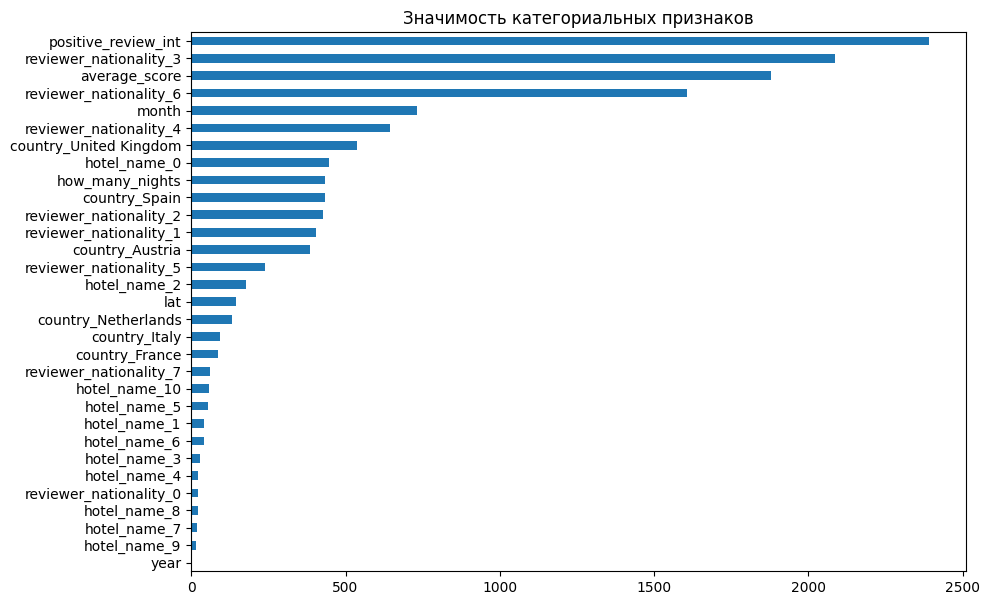

In [33]:
y=y.astype('int')

...
from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', figsize = (10,7), title = 'Значимость категориальных признаков')

<AxesSubplot: title={'center': 'Значимость непрерывных признаков'}>

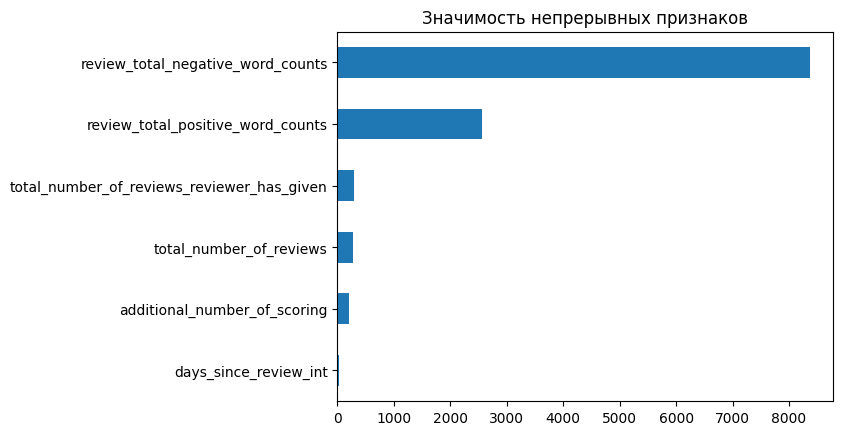

In [34]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title = 'Значимость непрерывных признаков')

Удаляем менее значимые и сильно скореллированные признаки

In [35]:
data.drop(['lat', 'lng', 'year', 'additional_number_of_scoring'], axis=1, inplace=True)

<AxesSubplot: >

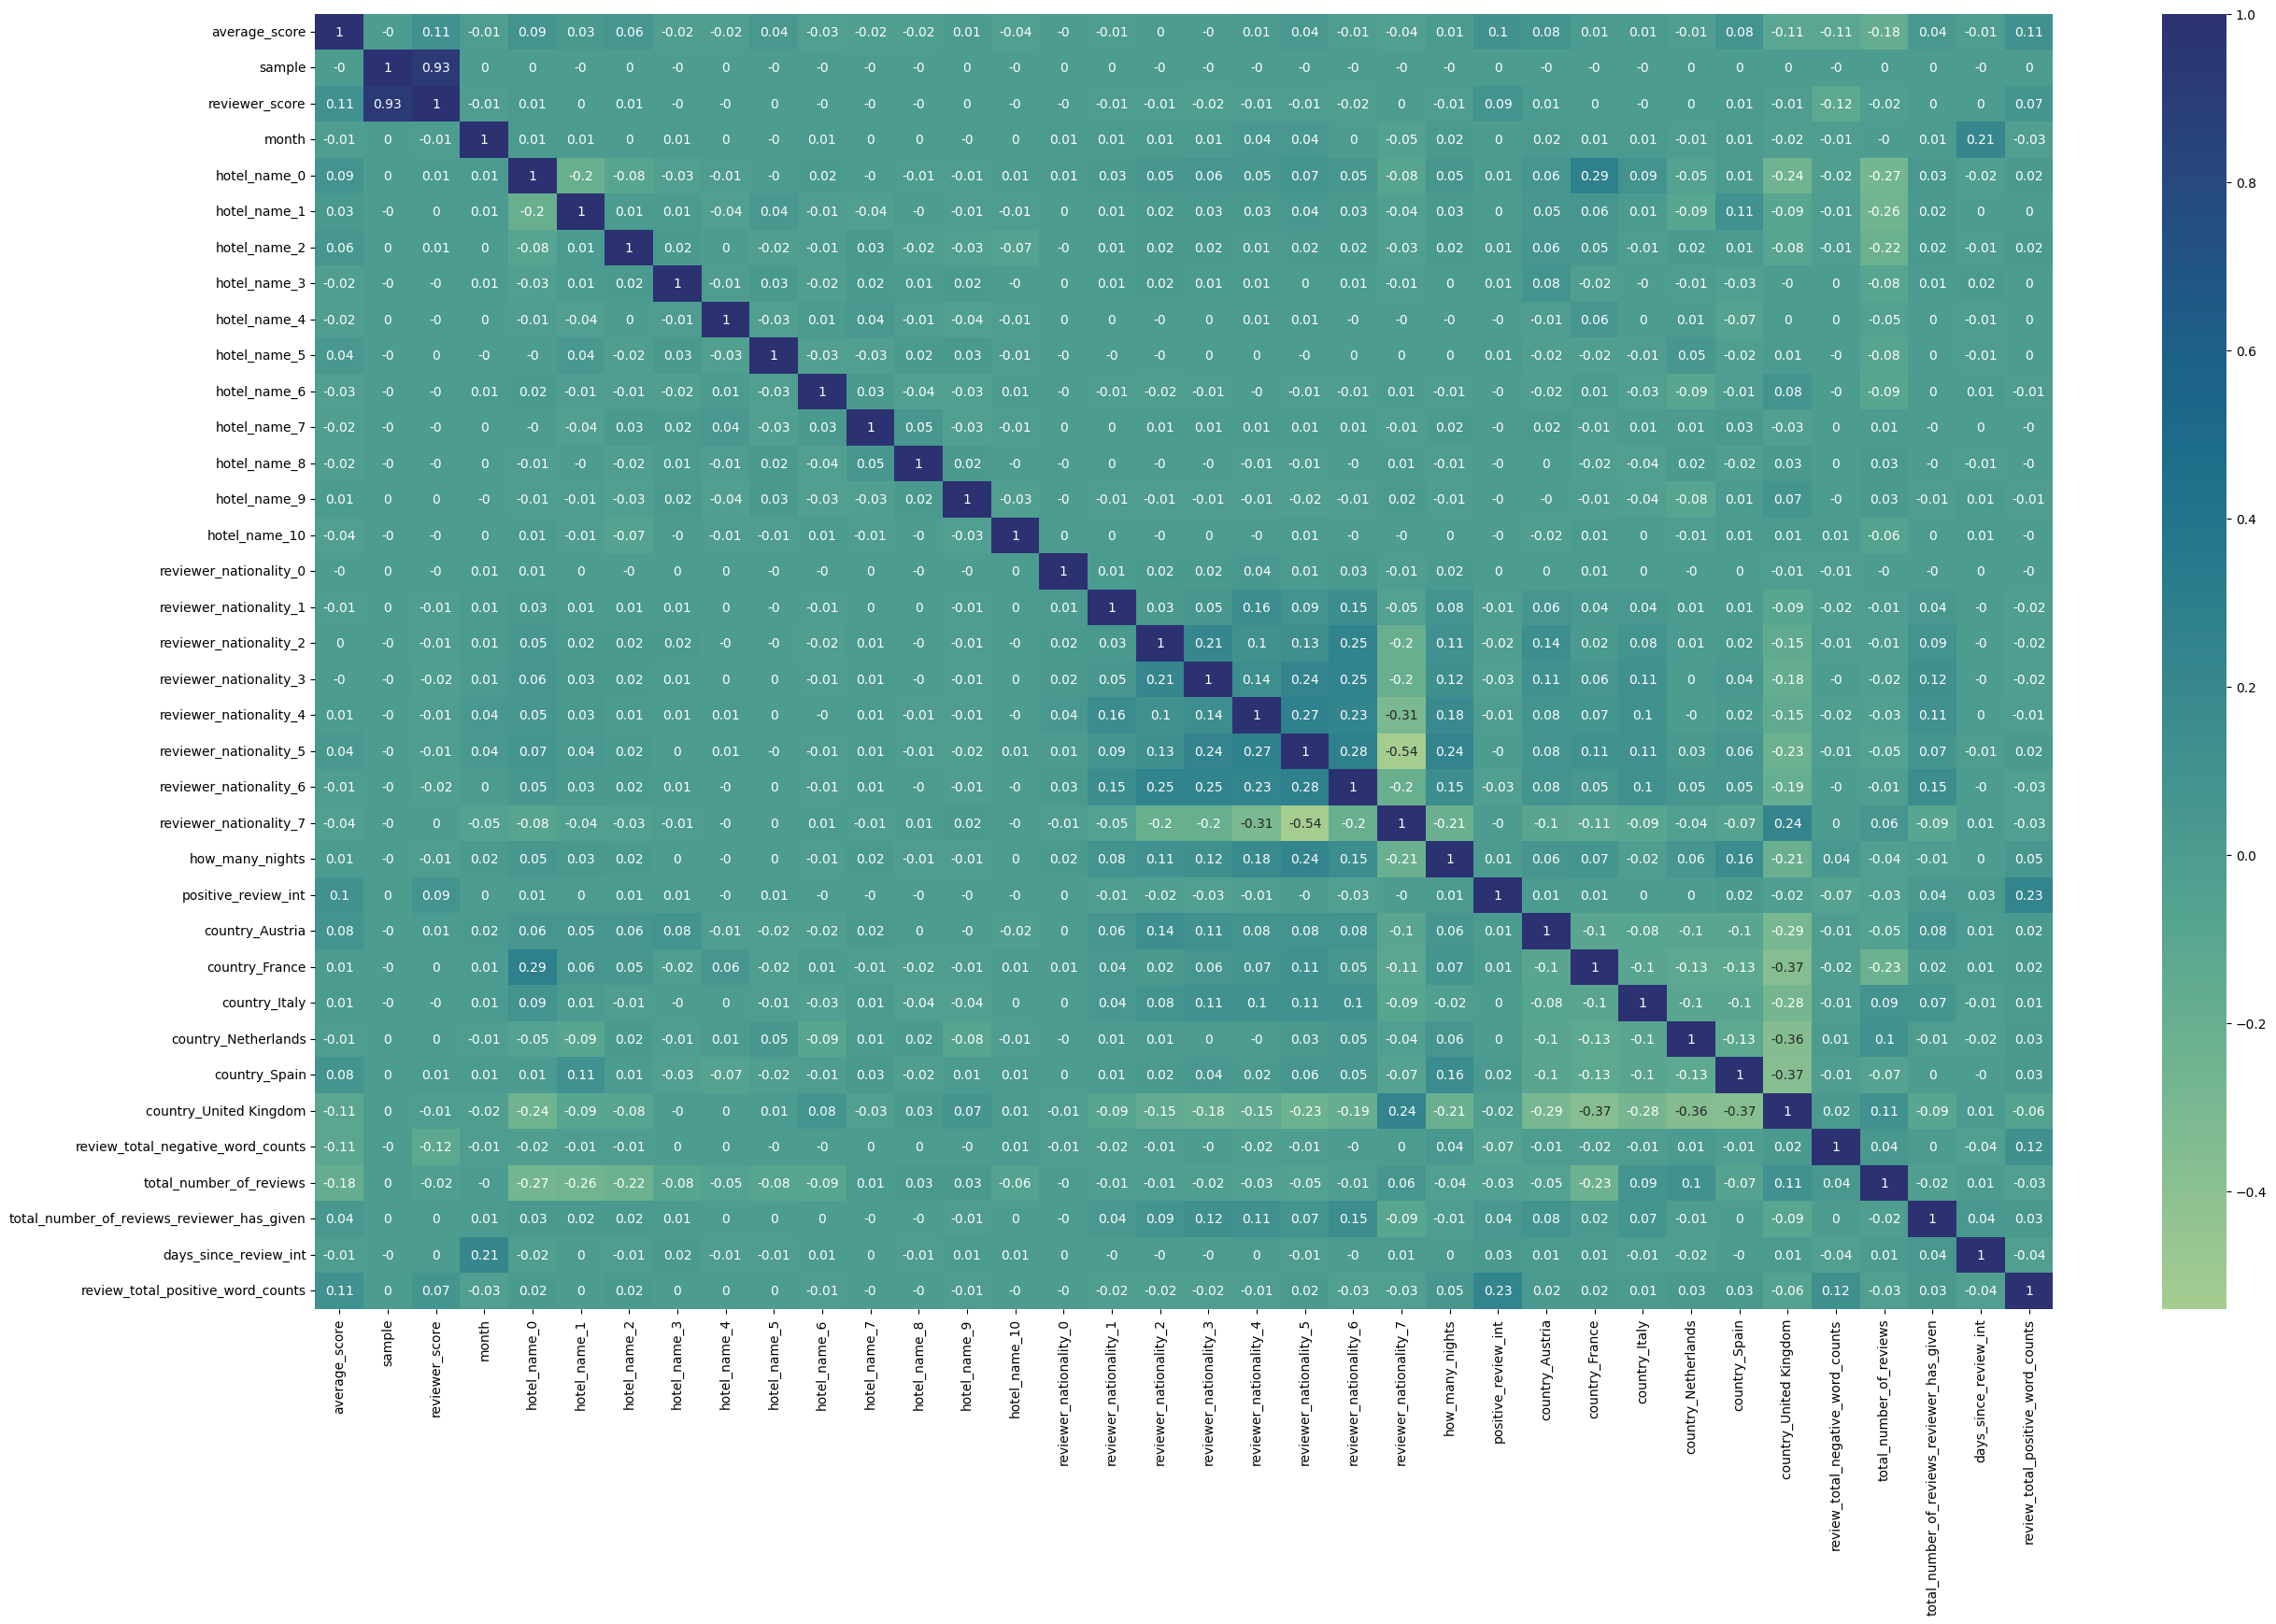

In [36]:
fig = plt.figure(figsize=(30, 18))
sns.heatmap(round(data.corr(), 2), annot=True, cmap="crest")

# Обучение модели

In [37]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [39]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
from sklearn.model_selection import train_test_split
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [40]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [41]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [42]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.1s finished


In [43]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test) и смотрим, насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений в отношении фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13479021826948112


In [44]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.9388052875172118


In [45]:
test_data.sample(5)

,average_score,reviewer_score,month,hotel_name_0,hotel_name_1,hotel_name_2,hotel_name_3,hotel_name_4,hotel_name_5,hotel_name_6,...,country_France,country_Italy,country_Netherlands,country_Spain,country_United Kingdom,review_total_negative_word_counts,total_number_of_reviews,total_number_of_reviews_reviewer_has_given,days_since_review_int,review_total_positive_word_counts
7858,9.0,0.0,12,0,1,1,0,1,0,0,...,0,0,0,0,1,0.000000,0.081253,0.011299,0.836986,0.040506
28142,8.1,0.0,2,0,0,0,0,0,0,1,...,0,0,0,0,1,0.000000,0.424731,0.000000,0.250685,0.055696
50828,8.2,0.0,2,0,0,0,1,0,1,1,...,0,0,1,0,0,0.071078,0.212005,0.056497,0.713699,0.098734
109036,8.4,0.0,7,0,0,0,1,1,1,1,...,0,0,0,0,1,0.000000,0.126120,0.005650,0.023288,0.055696
52266,8.6,0.0,4,0,0,0,0,1,1,1,...,0,1,0,0,0,0.004902,0.237986,0.031073,0.135616,0.207595


In [46]:
test_data.drop(['reviewer_score'], axis=1, inplace=True)

In [47]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.5s finished


In [48]:
list(submission)

['reviewer_score', 'id']

In [49]:
submission['reviewer_score'] = predict_submission
submission.to_csv('output/submission.csv', index=False)
submission.head(10)

,reviewer_score,id
0,8.408,488440
1,7.309,274649
2,7.754,374688
3,9.340,404352
4,9.702,451596
5,9.006,302161
6,8.292,317079
7,7.998,13963
8,8.555,159785
9,7.877,195089
